# Surplus Study  - Surplus/LVR Historic COW  

**The purpose of this study is to measure the surplus for historic COW trades for a desired token pair.** 


**Definitions:**  
X = reserves of token1  
Y = reserves of token2  
dx = trade quantity of token1 for a given trade  
dy = trade quantity of token2 for a given trade   

**Surplus Calculations:** 

Surplus is defined by (Pfeedlot - Pmarket) * quantity 


- Surplus_price: defined as the surplus in price terms defined as follows:
    - Pfeedlot = X / Y 
    - Pmarket = dx / dy
    - surplus_ price = Pfeedlot - Pmarket 
      
- Surplus_usdt: Surplus volume in USDT terms defined as follows: 
    - surplus_price * dy  

Note: Since P is defined generally here as X / Y (or dx / dy for a swap) then the quantity to multiply to obtain surplus is dy. 




**Methodology:** 
- Assume a Feedlot AMM with CPMM preferences that only trades COW orders. Given by XY = K  
    where:  
        X = reserves of token1   
        Y = reserves of token2  
        K = X * Y  
        
- Feedlot AMM trades at the COW settelement price (which is the solver price) if the trade offers satisfies the preferences (k_new > k_current) and retains any difference (surplus) 
          
- Given a dataset that represents the list of all trades that happened on COW Swap with value over USD 250 with first trade at timestamp $t_0$. 
- Model Inputs: 
    - `token1`: Token1 of token pair to be studied 
    - `Token2`: Token2 of token pair to be studied 
    - `token1_starting_reserves`: Starting reserves of the feedlot AMM pool. 
    - `fee_rate`: Fee rate charged to the trade 
  
- Initialize a feedlot AMM for token1 and token2, at $t_0$ with the price of the first trade at t0 of the COW dataset of token1 and token2, using the starting reserves given by the input (calculating token1_starting_reserves * price at $t_0$) 

- Loop through all trades and check at each trade if $P_Feedlot$ < $P_Cow_execution$. (This is also given by $k_new$ > k_current). If the price of feedlot was favourable then trade is executed on Feedlot AMM and new reserves are updated. 

### 1. Loading COW Dataset 

Copy the dataset file into the folder that contains this notebook. 

In [1]:
from datastreams.datastream import Streamer

import matplotlib.pyplot as plt
import pandas as pd
import polars as pl

# These commands enlarge the column size of the dataframe so things like 0x... are not truncated
pd.set_option('display.max_columns', None)
pd.set_option('display.expand_frame_repr', False)
pd.set_option('max_colwidth', None)

In [2]:
# instantiate Streamer class. Note that we need two separate streamer classes, otherwise the queries will be overwritten. 
cow_ds = Streamer('https://api.thegraph.com/subgraphs/name/cowprotocol/cow')

In [3]:
# DEFINE TIMESTAMP HERE. Minimum Timstamp is used for replication quality assurance purposes. Timestamp date: 
timestamp =  1646092800

# we set a fixed query size number. The Cow settlements and Uniswap swaps query are multiples larger than this initial query size.
query_size = 500000

#Filter size - We filter trades out that are smaller than $1000 USD size
filter_usd = 100

In [4]:
# query COW schema: trades
trades_fp = cow_ds.queryDict.get('trades')

# trades query path that gets token a -> token b trades. Query on query_size. 
trades_qp = trades_fp(
    first=query_size,
    orderBy='timestamp',
    orderDirection='desc',
    where = {
    'timestamp_gt': timestamp
    }
)

# run query
trades_df = cow_ds.runQuery(trades_qp)

FIELD - trades


In [113]:
print(f'query returned {len(trades_df)} rows')

query returned 331802 rows


In [130]:
trades_df.head(5)

,trades_id,trades_timestamp,trades_gasPrice,trades_feeAmount,trades_txHash,trades_settlement_id,trades_buyAmount,trades_sellAmount,trades_sellToken_id,trades_buyToken_id,trades_order_id,trades_buyAmountEth,trades_sellAmountEth,trades_buyAmountUsd,trades_sellAmountUsd,endpoint
0,0xa6f3d0560e61e77eace4e15ff44ff0743a4a48f28de85b9e31dd8aac1160c68c0582fc81f21686541623de723448c21e1e443522640ef9d0|0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942|145,1678697171,18901538318,57740371011993296896,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,5960372533464009646,75000400000000000000000,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xa6f3d0560e61e77eace4e15ff44ff0743a4a48f28de85b9e31dd8aac1160c68c0582fc81f21686541623de723448c21e1e443522640ef9d0,5.9604,0.0000,9638.6062,0.0000,cow
1,0x9fb2365e569b1c0d5a67ee6df4d2cfedcbd27e8428c85b9a689f7c9c827d81d85ac0210e0d6d03cbdf85511474f5f714d25ee183640ef9c2|0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942|145,1678697171,18901538318,4110177118564564992,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,22062282427,6331735533211306433308,0xc0c293ce456ff0ed870add98a0828dd4d2903dbf,0xdac17f958d2ee523a2206206994597c13d831ec7,0x9fb2365e569b1c0d5a67ee6df4d2cfedcbd27e8428c85b9a689f7c9c827d81d85ac0210e0d6d03cbdf85511474f5f714d25ee183640ef9c2,13.6430,13.9606,22062.2824,22586.8324,cow
2,0x01677bcd2d56006fba89e82dc5d636000a33063e77740ab9726d39938642b980ecbaf5c200b290caa0ce63a098a34808ea8c46f7640ef97b|0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942|145,1678697171,18901538318,1589781568748924,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,8439662236627212,10034390284677249,0xae7ab96520de3a18e5e111b5eaab095312d7fe84,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0x01677bcd2d56006fba89e82dc5d636000a33063e77740ab9726d39938642b980ecbaf5c200b290caa0ce63a098a34808ea8c46f7640ef97b,0.0084,0.0100,13.6479,16.0041,cow
3,0xc39619df51e440d4deac17956afe5b18dec61d7b2b1f7bce28ebb1956314fb129fa6c303300ed23cefb0b1106ae898810dc01cc3640ee92e|0x6e872ab8fab8d5d7a5ba6314d09a3e58a1af2098f5c5d7337b5b3ffc0b3f1eed|46,1678697075,18059272064,3883604,0x6e872ab8fab8d5d7a5ba6314d09a3e58a1af2098f5c5d7337b5b3ffc0b3f1eed,0x6e872ab8fab8d5d7a5ba6314d09a3e58a1af2098f5c5d7337b5b3ffc0b3f1eed,427576131123171816474,1195800000,0xdac17f958d2ee523a2206206994597c13d831ec7,0x03ab458634910aad20ef5f1c8ee96f1d6ac54919,0xc39619df51e440d4deac17956afe5b18dec61d7b2b1f7bce28ebb1956314fb129fa6c303300ed23cefb0b1106ae898810dc01cc3640ee92e,0.7413,0.7391,1208.2066,1195.8000,cow
4,0x13ad7e69413a0ac1c909fa302cd28716b56dfbbaff1737d9fa511a2d9034b1504179284c327b35ef08016f9112b8a4867207e79a640ee908|0x48f48d92be321b0f9d92c866c3e4517b59483dd9fae9368bb373dd5946281fdd|103,1678697039,15685415532,15747396302561077248,0x48f48d92be321b0f9d92c866c3e4517b59483dd9fae9368bb373dd5946281fdd,0x48f48d92be321b0f9d92c866c3e4517b59483dd9fae9368bb373dd5946281fdd,243839109141077509,2326905897847167316748,0xe60779cc1b2c1d0580611c526a8df0e3f870ec48,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0x13ad7e69413a0ac1c909fa302cd28716b56dfbbaff1737d9fa511a2d9034b1504179284c327b35ef08016f9112b8a4867207e79a640ee908,0.2438,0.0000,394.5055,0.0000,cow


In [131]:
# Set query size large enough to retrieve all tokens in the graph
query_size_token = 10000000

token_fp = cow_ds.queryDict.get('tokens')

# add parameters to the settlements_qp.
token_qp = token_fp(
    first=query_size_token,
)

# run query
token_df = cow_ds.runQuery(token_qp)

FIELD - tokens


In [132]:
# Merge1 on sell token address.  x = sell token 

merged_df = pd.merge(trades_df, token_df, left_on='trades_sellToken_id', right_on='tokens_address')

In [133]:
# Merge2 on buy token address.  y = buy token 
merged_df2 = pd.merge(merged_df, token_df, left_on='trades_buyToken_id', right_on='tokens_address')

In [134]:
df = merged_df2.rename(columns={
    "tokens_symbol_x": "sell_token_symbol",
    "tokens_symbol_y":"buy_token_symbol",
    "tokens_decimals_x": "sell_token_decimal", 
    "tokens_decimals_y": "buy_token_decimal"})

In [135]:
df.head(5)

,trades_id,trades_timestamp,trades_gasPrice,trades_feeAmount,trades_txHash,trades_settlement_id,trades_buyAmount,trades_sellAmount,trades_sellToken_id,trades_buyToken_id,trades_order_id,trades_buyAmountEth,trades_sellAmountEth,trades_buyAmountUsd,trades_sellAmountUsd,endpoint_x,tokens_id_x,tokens_address_x,tokens_firstTradeTimestamp_x,tokens_name_x,sell_token_symbol,sell_token_decimal,tokens_totalVolume_x,tokens_priceEth_x,tokens_priceUsd_x,tokens_numberOfTrades_x,tokens_totalVolumeUsd_x,tokens_totalVolumeEth_x,endpoint_y,tokens_id_y,tokens_address_y,tokens_firstTradeTimestamp_y,tokens_name_y,buy_token_symbol,buy_token_decimal,tokens_totalVolume_y,tokens_priceEth_y,tokens_priceUsd_y,tokens_numberOfTrades_y,tokens_totalVolumeUsd_y,tokens_totalVolumeEth_y,endpoint
0,0xa6f3d0560e61e77eace4e15ff44ff0743a4a48f28de85b9e31dd8aac1160c68c0582fc81f21686541623de723448c21e1e443522640ef9d0|0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942|145,1678697171,18901538318,57740371011993296896,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,5960372533464009646,75000400000000000000000,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xa6f3d0560e61e77eace4e15ff44ff0743a4a48f28de85b9e31dd8aac1160c68c0582fc81f21686541623de723448c21e1e443522640ef9d0,5.9604,0.0000,9638.6062,0.0000,cow,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xfd0205066521550d7d7ab19da8f72bb004b4c341,1673609795,Liquidity Incentive Token,LIT,18,199698955264255269058507137,0.0000,0.0000,2226,34695.6825,21.4961,cow,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,1628150700,,,18,1513963044900408655298413,1.0000,1599.4822,132870,2925186516.9278,1513963.0449,cow
1,0xb4a7499f89e945dc83f203c534b5d778489e41fe4b083987f2334a5f8a585dce8cd6f461662451688e8cfc3cfdeeac55bc3b8648640ec917|0x2b3256a8254fe188bd99e661d6cf0a30b4a5d305671c017b7dd5ae00235516b4|77,1678684619,15570611508,25586676311281516544,0x2b3256a8254fe188bd99e661d6cf0a30b4a5d305671c017b7dd5ae00235516b4,0x2b3256a8254fe188bd99e661d6cf0a30b4a5d305671c017b7dd5ae00235516b4,120000000000000000,1511201804103806248025,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xb4a7499f89e945dc83f203c534b5d778489e41fe4b083987f2334a5f8a585dce8cd6f461662451688e8cfc3cfdeeac55bc3b8648640ec917,0.1200,0.0000,193.6748,0.0000,cow,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xfd0205066521550d7d7ab19da8f72bb004b4c341,1673609795,Liquidity Incentive Token,LIT,18,199698955264255269058507137,0.0000,0.0000,2226,34695.6825,21.4961,cow,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,1628150700,,,18,1513963044900408655298413,1.0000,1599.4822,132870,2925186516.9278,1513963.0449,cow
2,0x7cfd93136f35bb5324a2be2a99e56746f2f3e2b751d02fd09117a8da00f594524098503de63ca5c0686c1cc952138f928b7b9aab640e7cc7|0x92c4819edf00f82a4bf229204f625fcf4189e0492370f7bbcb7a99969c64fd58|212,1678665083,41018039430,117280370428390195200,0x92c4819edf00f82a4bf229204f625fcf4189e0492370f7bbcb7a99969c64fd58,0x92c4819edf00f82a4bf229204f625fcf4189e0492370f7bbcb7a99969c64fd58,224290500967350164,3000000000000000000000,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0x7cfd93136f35bb5324a2be2a99e56746f2f3e2b751d02fd09117a8da00f594524098503de63ca5c0686c1cc952138f928b7b9aab640e7cc7,0.2243,0.0000,358.3995,0.0000,cow,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xfd0205066521550d7d7ab19da8f72bb004b4c341,1673609795,Liquidity Incentive Token,LIT,18,199698955264255269058507137,0.0000,0.0000,2226,34695.6825,21.4961,cow,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,1628150700,,,18,1513963044900408655298413,1.0000,1599.4822,132870,2925186516.9278,1513963.0449,cow
3,0x72f1b9e2b5cfb380b6f1d4978db33a0938f3261e8e4c155f3ec8ca05fbcd1bdc0e242b564e89ff2cc2d3c25354bb923feb5c1e0d640e4aae|0x320f21701f23073cc3e0f

In [136]:
df.shape

(331802, 42)

In [137]:
df.dtypes

trades_id                        object
trades_timestamp                  int64
trades_gasPrice                   int64
trades_feeAmount                 object
trades_txHash                    object
trades_settlement_id             object
trades_buyAmount                 object
trades_sellAmount                object
trades_sellToken_id              object
trades_buyToken_id               object
trades_order_id                  object
trades_buyAmountEth             float64
trades_sellAmountEth            float64
trades_buyAmountUsd             float64
trades_sellAmountUsd            float64
endpoint_x                       object
tokens_id_x                      object
tokens_address_x                 object
tokens_firstTradeTimestamp_x      int64
tokens_name_x                    object
sell_token_symbol                object
sell_token_decimal                int64
tokens_totalVolume_x             object
tokens_priceEth_x               float64
tokens_priceUsd_x               float64


In [138]:
df = df[[
    'trades_id',                        
    'trades_timestamp',                  
    'trades_gasPrice',                   
    'trades_feeAmount',                 
    'trades_txHash',                    
    'trades_buyAmount',                 
    'trades_sellAmount',                
    'trades_sellToken_id',              
    'trades_buyToken_id',               
    'trades_buyAmountUsd',             
    'trades_sellAmountUsd',            
    'sell_token_symbol',                
    'sell_token_decimal',                
    'buy_token_symbol',                 
    'buy_token_decimal'                 
    
]]

In [139]:
df.head(3)

,trades_id,trades_timestamp,trades_gasPrice,trades_feeAmount,trades_txHash,trades_buyAmount,trades_sellAmount,trades_sellToken_id,trades_buyToken_id,trades_buyAmountUsd,trades_sellAmountUsd,sell_token_symbol,sell_token_decimal,buy_token_symbol,buy_token_decimal
0,0xa6f3d0560e61e77eace4e15ff44ff0743a4a48f28de85b9e31dd8aac1160c68c0582fc81f21686541623de723448c21e1e443522640ef9d0|0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942|145,1678697171,18901538318,57740371011993296896,0x281baeb30881c0a2b8fd90345101a9b65833a761099bc77ba2696a4c99283942,5960372533464009646,75000400000000000000000,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,9638.6062,0.0000,LIT,18,,18
1,0xb4a7499f89e945dc83f203c534b5d778489e41fe4b083987f2334a5f8a585dce8cd6f461662451688e8cfc3cfdeeac55bc3b8648640ec917|0x2b3256a8254fe188bd99e661d6cf0a30b4a5d305671c017b7dd5ae00235516b4|77,1678684619,15570611508,25586676311281516544,0x2b3256a8254fe188bd99e661d6cf0a30b4a5d305671c017b7dd5ae00235516b4,120000000000000000,1511201804103806248025,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,193.6748,0.0000,LIT,18,,18
2,0x7cfd93136f35bb5324a2be2a99e56746f2f3e2b751d02fd09117a8da00f594524098503de63ca5c0686c1cc952138f928b7b9aab640e7cc7|0x92c4819edf00f82a4bf229204f625fcf4189e0492370f7bbcb7a99969c64fd58|212,1678665083,41018039430,117280370428390195200,0x92c4819edf00f82a4bf229204f625fcf4189e0492370f7bbcb7a99969c64fd58,224290500967350164,3000000000000000000000,0xfd0205066521550d7d7ab19da8f72bb004b4c341,0xeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeeee,358.3995,0.0000,LIT,18,,18


In [140]:
# calculate buy and sell amounts from the correct decimal 
df['buy_amount'] = df.apply(lambda x: x['trades_buyAmount'] / (10**x['buy_token_decimal']), axis=1)
df['sell_amount'] = df.apply(lambda x: x['trades_sellAmount'] / (10**x['sell_token_decimal']), axis=1)

In [141]:
# Add new empty columns needed for analysis & specify their data types 
df['cow_price'] = 0.0                  
df['pool_initial_price'] = 0.0  # price of the pool before accounting for trade impact. Perhaps change to compute actual trade price. 
df['surplus_usdt'] = 0.0            
df['surplus_price'] = 0.0          
df['surplus_percent'] = 0.0        
df['executed'] = False     
df['k']=0.0  #23
df['k_new']=0.0 #24

df['cow_price'] = df['cow_price'].astype(float)
df['pool__initial_price'] = df['pool_initial_price'].astype(float)
df['surplus_usdt'] = df['surplus_usdt'].astype(float)
df['surplus_price'] = df['surplus_price'].astype(float)
df['surplus_percent'] = df['surplus_percent'].astype(float)
df['executed'] = df['executed'].astype(bool)
df['k'] = df['k'].astype(float)
df['k_new'] =df['k_new'].astype(float) 

In [142]:
df.dtypes

trades_id                object
trades_timestamp          int64
trades_gasPrice           int64
trades_feeAmount         object
trades_txHash            object
trades_buyAmount         object
trades_sellAmount        object
trades_sellToken_id      object
trades_buyToken_id       object
trades_buyAmountUsd     float64
trades_sellAmountUsd    float64
sell_token_symbol        object
sell_token_decimal        int64
buy_token_symbol         object
buy_token_decimal         int64
buy_amount              float64
sell_amount             float64
cow_price               float64
pool_initial_price      float64
surplus_usdt            float64
surplus_price           float64
surplus_percent         float64
executed                   bool
k                       float64
k_new                   float64
pool__initial_price     float64
dtype: object

## 2. Surplus calculation function 

Detailed steps of the function: 

1. Filter the dataset for token1 and token2 trades only
2. Calculate price for each trade based on whether token1 was the buy or token2. Price defined as Token1/Token2. 
3. Use the price of the first trade to initialize the feedlot AMM pool with token1_starting_reserves
3. Loop through trades and check if k_new > k and if yes, execute trade by reflecting new reserves level 

Note about fees calculation:
For the purpose of this study we wish to study the actual historic trades without altering the quantities traded by the traders, as this reflects the true prices the traders were willing to accept trading at. This means the dx and dy values do not change in the simulation and are kept as is. This means in the presence of fees in our model, it is assumed that there happens to be a value dx' which if applied fees to results in the dx given in the dataset: So dx'*(1+s)=dx 

So in order to arrive at dx we want, we did dx/(1+s) to estimate the trades that would have executed with a fee.   

In [143]:
from datetime import datetime
 

def surplus_analysis(token1:str, token2:str, token1_starting_reserves:int, fee_rate:float):
    
    """
    Perform surplus analysis for specific trading pair given by token1 and token2. 

    This function filters the required tokens for the simulation, initializes a feedlot AMM (CPMM) with starting 
    price corresponding to first trade in the list and a given initial reserves, loops through trade by trade and 
    checks if Pfeedlot < Pmarket. If yes (k_new > k_current), it executes the trade in Feedlot using the standard 
    CPMM formula. 

    Parameters:
        token1 (str): The first token to perform the surplus analysis on.
        token2 (str): The second token to perform the surplus analysis on.
        starting_reserves (int): The starting reserves of token1. 
        fee_rate (float): The fee rate for the transactions.

    Returns:
        trades_executed_percentage : Percentage of trades executed on Feedlot AMM that met the condition Pfeedlot < Pmarket
        executed_volume_percentage : volume of executed trades as percentage of total volume of swaps for token1 and token2
        total_surplus: Sum of surplus in USD terms 
    
    """
    
    
    # Filter the required tokens for the simulation 
   
    dfs = df[((df.buy_token_symbol == token1) & (df.sell_token_symbol == token2)) | ((df.sell_token_symbol == token1) & (df.buy_token_symbol == token2))]
    dfs.sort_values(by='trades_timestamp', ascending=False, inplace=True)
    dfs = dfs[dfs['trades_sellAmountUsd'] > 250]
    dfs = dfs.reset_index(drop=True)
    #dfs.to_csv('raw_trades_dataset.csv', index=False)
    
    print('dfs', len(dfs), 'trades in sample')


    # Calculate price column. Only important for analysis is first price to initialize pool with it. 
    # Check if its a buy or a sell and calculate accordingly. 
    for i in range(len(dfs)):
        if dfs.loc[i,'sell_token_symbol'] == token1:
            dfs.loc[i,'cow_price'] = dfs.loc[i,'sell_amount'] / dfs.loc[i,'buy_amount']  

        if dfs.loc[i,'sell_token_symbol'] == token2:
            dfs.loc[i,'cow_price'] = dfs.loc[i,'buy_amount'] / dfs.loc[i,'sell_amount']     
    dfs = dfs[dfs['cow_price'] != 0]
    
    print('price column added')
    
    
    # initialize AMM pool 
    s = fee_rate 
    initialization_price = dfs.loc[dfs.index[-1],'cow_price']  
    token2_starting_reserves = token1_starting_reserves / initialization_price
    x = token1_starting_reserves 
    y = token2_starting_reserves 
    k = x * y 
    k_new = k 
    
    print('****** Feedlot AMM Initial State **********')
    print('''AMM Initialized with the following parameters:
    initilization price = {}
    x= {}
    y= {}
    k= {}
    s= {}'''.format(initialization_price, token1_starting_reserves, token2_starting_reserves, k, s))


    # Iterating through trades and checking if the trade would have been executed through Feedlot AMM
    # The condition is k_new > k  
    # Variables to monitor (trades: total trades executed, fees: total fees collected, volume : total volume executed) 

    trades  = 0 
    fees_collected = 0 
    volume = 0 
    
    for i in range(len(dfs)):
        
        dfs.loc[i,'pool_initial_price'] = x / y 
        dfs.loc[i,'k'] = k

        # if token_1 is the "buy token"
        if dfs.loc[i,'buy_token_symbol'] == token1:
            dx = dfs.loc[i,'buy_amount']
            dy = dfs.loc[i,'sell_amount']
            k_new = (x - dx) * (y + (dy/(1+s))) 
            dfs.loc[i,'k_new'] = k_new
            
            if k_new > k:
                surplus_price = abs((x / y)- dfs.loc[i,'cow_price'])
                dfs.loc[i,'surplus_usdt'] =  surplus_price * dy  # surplus in dollar volume surplus  
                dfs.loc[i,'surplus_price'] = surplus_price
                dfs.loc[i,'surplus_percent'] = surplus_price / dfs.iloc[i,6] * 100 # percentage
                dfs.loc[i,'executed'] = 1 # trade executed signal 
                volume = volume + dfs.loc[i,'trades_sellAmountUsd']
                fees_collected = fees_collected + (s * dfs.loc[i,'trades_sellAmountUsd']) 
                trades = trades + 1 
                k = k_new 
                x = x - dx
                y = y + dy/(1+s)

        # if token_2 is the "buy token"
        elif dfs.loc[i,'buy_token_symbol'] == token2:
            dx = dfs.loc[i,'sell_amount'] 
            dy = dfs.loc[i,'buy_amount']
            k_new = (x + (dx/(1+s))) * (y - dy) 
            dfs.loc[i,'k_new'] = k_new

            if k_new > k: 
                surplus_price = abs((x / y)- dfs.loc[i,'cow_price'])
                dfs.loc[i,'surplus_usdt'] =  surplus_price * dy  # surplus in dollar volume terms 
                dfs.loc[i,'surplus_price'] = surplus_price
                dfs.loc[i,'surplus_percent'] = surplus_price / dfs.iloc[i,6] * 100 # percentage
                dfs.loc[i,'executed'] = 1 # trade executed signal 
                volume = volume + dfs.loc[i,'trades_sellAmountUsd']
                fees_collected = fees_collected + (s * dfs.loc[i,'trades_sellAmountUsd']) 
                trades = trades + 1 
                k = k_new 
                x = x + dx/(1+s)
                y = y - dy

    #dfs.to_csv('debug4.csv', index=False)

    # Analysis results 
    
    total_trades = len(dfs)
    
    # use the sell amount USD provided in subgraph as an estimate for total trade volume
    total_volume = dfs['trades_sellAmountUsd'].sum()
    total_surplus = dfs['surplus_usdt'].sum() 

    trades_executed_percentage = trades / total_trades * 100 
    executed_volume_percentage = volume / total_volume * 100 
    total_surplus_percentage = total_surplus/ total_volume *100
    
    
    # calculate return metrics 
    starting_date = datetime.utcfromtimestamp(dfs.iloc[0,1]).strftime('%Y-%m-%d')
    ending_date = datetime.utcfromtimestamp(dfs.iloc[-1,1]).strftime('%Y-%m-%d')
    # divide by 3600 because timestamp is in unix10 format which is in seconds. 
    days = (datetime.utcfromtimestamp(dfs.iloc[0,1]) - datetime.utcfromtimestamp(dfs.iloc[-1,1]))
    
    ending_reserves_1 = x 
    ending_reserves_2 = y 
    
    print('******** Results Data **********************')
    print('  Inputs:')
    print('token1', token1)
    print('token2', token2)
    print('initial Reserves', token1_starting_reserves)
    print('fee rate')
    print('  dataset timeframe:')
    print('starting date', datetime.utcfromtimestamp(dfs.iloc[0,1]).strftime('%Y-%m-%d'))
    print('ending date', datetime.utcfromtimestamp(dfs.iloc[-1,1]).strftime('%Y-%m-%d'))
    print('days', days)
    print('  Trades:')
    print('trades executed = ', trades)
    print('total_trades= ', total_trades)
    print('percentage of trades executed = ', trades_executed_percentage, '%') 
    print('  Volume:')
    print('total usd volume traded on feedlot= ', volume)
    print('total USD volume traded on COW', total_volume)
    print('volume percentage = ', volume / total_volume *100 , '%')
    print('  Surplus:')
    print('total surplus', total_surplus)
    print('surplus percentage of volume', total_surplus_percentage, '%')
    print('  LP metrics:')
    print('fees collected', fees_collected)  
    print('ending reserves token1', x)
    print('ending reserves token2', y)
    
    
    return trades_executed_percentage, executed_volume_percentage, total_surplus
                


## 3. USDC-WETH – comparison with real UNIv2 returns 

**Methodology**

This simulation aims to compare a proposed Feedlot AMM that executes COW trades at the COW solver UCP price. It is initialized with the same reserves of UNIv2 USDC-WETH pool at the start of the period. 

Use same fees as UNIv2 of 0.3% 

Filter out trades with values < 250 USDC

COW Dataset:                250,000 trades    
of which USDC-WETH trades:  13,206  trades

#### 3.1 Get UNI V2 returns 

In [34]:
len(df)

331802

In [35]:
tokena = 'USDC'
tokenb = 'WETH'

In [36]:
weth_usdc_df = df[((df.buy_token_symbol == tokena) & (df.sell_token_symbol == tokenb)) | ((df.sell_token_symbol == tokena) & (df.buy_token_symbol == tokenb))]

In [37]:
weth_usdc_df = weth_usdc_df[weth_usdc_df['trades_sellAmountUsd'] > 250]
weth_usdc_df.sort_values(by='trades_timestamp', ascending=False, inplace=True)

In [38]:
len(weth_usdc_df)

17073

In [ ]:
# 17,073 trades that are WETH-USDC out of 331,802

In [39]:
# last trade
weth_usdc_df.iloc[0,1]

1678695899

In [40]:
weth_usdc_df.iloc[0,4]

'0xa0172a34527f45632cd16bfe9c70fdea373098c2b854dbcb592923f83f201243'

In [41]:
# Block Number last = 16817867
# https://etherscan.io/tx/0xa0172a34527f45632cd16bfe9c70fdea373098c2b854dbcb592923f83f201243

In [71]:
weth_usdc_df.iloc[-1,1]

1646097479

In [72]:
weth_usdc_df.iloc[-1,4]

'0xab85eb2a998f6eaa54b3f10c0e3d3b2f5f55e1bb63d7042e2af7e7c679a477ec'

In [44]:
# Block Number first = 14298100

#https://etherscan.io/tx/0xab85eb2a998f6eaa54b3f10c0e3d3b2f5f55e1bb63d7042e2af7e7c679a477ec

In [73]:
days = (datetime.utcfromtimestamp(weth_usdc_df.iloc[0,1]) - datetime.utcfromtimestamp(weth_usdc_df.iloc[-1,1]))
days

datetime.timedelta(days=377, seconds=25620)

MANUAL WORK 

UNIv2 data obtained from Etherscan: Reserves values + LP token supply   

https://etherscan.io/tokencheck-tool?t=0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc

In [75]:
# Univ2 data at last trade:
# UNIV2 USDC_WETH Token supply @ 16760457 = 0.283752303355447465 

# UNIV2 USDC Reserves = 24,534,052.128565
# UNIV2 WETH reserves = 15,116.085248152227807536 


In [76]:
# Univ2 data at first trade
# Block number =  4298100

# UNIV2 USDC_WETH Token supply @ 4298100 = 1.021288427515729217 


# UNIV2 USDC Reserves = 104,656,103.720135  USDC
# UNIV2 WETH reserves = 35,707.054138286841628182  WETH

In [77]:
# Simple TVL assuming 1.00 USDC = 1.00 USD

In [79]:
# Assume value of reserves of USDC = value of reserves of WETH. Hence simply multiply by 2 to obtain pool value. 

LP_token_value_end = (24534052.128565 *2) / 0.283752303355447465 
LP_token_value_end

172925835.93819833

In [80]:
LP_token_value_start = (104656103.720135 *2) / 1.021288427515729217 
LP_token_value_start

204949162.05935988

In [81]:
r = LP_token_value_end/LP_token_value_start
r

0.8437499046134838

In [82]:
annual_return = 365 / 295 * (r-1) + 1
annual_return

0.8066736107929544

In [53]:
# 8.44 % annual returns. This includes all fees and capital gains. 

In [54]:
# get total volume traded in that pool 

In [55]:
uni_ds = Streamer('https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2')

In [62]:
date_gt = weth_usdc_df.iloc[-1,1]
date_gt

1646097479

In [66]:
# date_gt = weth_usdc_df.iloc[-1,1] which is 1646097479 for this simulation. Change it it accordingly below to 
# obtain the right corresponding UNIv2 volume data. 

# query COW schema: trades
uni_pool_fp = uni_ds.queryDict.get('pairDayDatas')

# trades query path that gets token a -> token b trades. Query on query_size. 
uni_pool_qp = uni_pool_fp(
    first=2000,
    orderBy='date',
    orderDirection='desc',
    where = {
    'date_gt': 1646097479,
    'pairAddress': "0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc"
    }
)

# run query
uni_pool_df = uni_ds.runQuery(uni_pool_qp)

FIELD - pairDayDatas


In [67]:
len(uni_pool_df)

377

In [68]:
uni_pool_df.dtypes

pairDayDatas_id                    object
pairDayDatas_date                   int64
pairDayDatas_pairAddress           object
pairDayDatas_token0_id             object
pairDayDatas_token1_id             object
pairDayDatas_reserve0             float64
pairDayDatas_reserve1             float64
pairDayDatas_totalSupply          float64
pairDayDatas_reserveUSD           float64
pairDayDatas_dailyVolumeToken0    float64
pairDayDatas_dailyVolumeToken1    float64
pairDayDatas_dailyVolumeUSD       float64
pairDayDatas_dailyTxns              int64
endpoint                           object
dtype: object

In [69]:
uni_pool_df

,pairDayDatas_id,pairDayDatas_date,pairDayDatas_pairAddress,pairDayDatas_token0_id,pairDayDatas_token1_id,pairDayDatas_reserve0,pairDayDatas_reserve1,pairDayDatas_totalSupply,pairDayDatas_reserveUSD,pairDayDatas_dailyVolumeToken0,pairDayDatas_dailyVolumeToken1,pairDayDatas_dailyVolumeUSD,pairDayDatas_dailyTxns,endpoint
0,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19429,1678665600,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,2.438620e+07,15208.726676,0.283766,4.848232e+07,1.908759e+06,1185.668536,1.901495e+06,725,uniswap-v2
1,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19428,1678579200,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,2.440243e+07,15203.795148,0.283847,4.840944e+07,9.856379e+06,6293.382111,9.695459e+06,1869,uniswap-v2
2,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19427,1678492800,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,3.506137e+07,22834.944323,0.417181,6.909593e+07,5.769755e+07,34549.216002,5.454462e+07,3554,uniswap-v2
3,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19426,1678406400,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,4.020803e+07,27989.549449,0.495667,8.028544e+07,1.468791e+07,10365.684716,1.466835e+07,3336,uniswap-v2
4,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19425,1678320000,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,4.024273e+07,28027.214862,0.496489,8.053935e+07,7.263508e+06,4919.153849,7.267965e+06,3018,uniswap-v2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
372,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19057,1646524800,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.012799e+08,39714.329836,1.057493,2.026308e+08,1.759963e+07,6733.305192,1.761310e+07,2351,uniswap-v2
373,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19056,1646438400,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.034875e+08,38853.079962,1.057574,2.070242e+08,2.527348e+07,3987.569521,1.790535e+07,2244,uniswap-v2
374,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19055,1646352000,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.025716e+08,39168.178118,1.057423,2.049815e+08,2.581832e+07,9581.754030,2.582687e+07,2561,uniswap-v2
375,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc-19054,1646265600,0xb4e16d0168e52d35cacd2c6185b44281ec28c9dc,0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48,0xc02aaa39b223fe8d0a0e5c4f27ead9083c756cc2,1.070800e+08,37693.444193,1.060272,2.140149e+08,1.971964e+07,6851.645979,1.971997e+07,2507,uniswap-v2


In [70]:
# Total volume of USDC 
total_uni_volume = uni_pool_df['pairDayDatas_dailyVolumeToken0'].sum()
total_uni_volume

5526736406.432251

#### 3.2 Get Simulation Feedlot returns

In [89]:
# run simulation with starting USDC reserves = 104656103.720135 as per the UNIv2 pool 

surplus_analysis('USDC', 'WETH', 104656103.720135 , 0.003)

/tmp/ipykernel_14651/2370034067.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='trades_timestamp', ascending=False, inplace=True)


dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 104656103.720135
    y= 36667.98038755301
    k= 3837527958647.624
    s= 0.003
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 104656103.720135
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 377 days, 7:07:00
  Trades:
trades executed =  7130
total_trades=  17073
percentage of trades executed =  41.76184618989047 %
  Volume:
total usd volume traded on feedlot=  367692156.82366097
total USD volume traded on COW 1537175254.2109973
volume percentage =  23.919989332146148 %
  Surplus:
total surplus 30022682.990996353
surplus percentage of volume 1.9531073577167637 %
  LP metrics:
fees collected 1103076.4704709852
ending reserves token1 115727302.90481538
ending reserves token2 44265.665153862465


(41.76184618989047, 23.919989332146148, 30022682.990996353)

In [90]:
# ending value + the fees 
ending_value = 115727302.90481538*2 + 1103076.4704709852
ending_value

232557682.28010175

In [93]:
starting_value = 104656103.720135 * 2 
starting_value

209312207.44027

In [94]:
ret = ending_value / starting_value 
ret

1.111056469778358

In [96]:
# number of days: 377 
annual = ((ret -1) * 365/377 )+1
annual

1.1075215158331584

In [98]:
#normalize by total volume $1bn

feedlot_normalized = (ending_value - starting_value) / 1.5371752542109973  
feedlot_normalized 

15122202.088637706

In [99]:
univ2_normalized = (LP_token_value_end - LP_token_value_start) / 5.526736406432251
univ2_normalized

-5794256.097303906

In [101]:
# also normalize the percentage return per $1bn. FEEDLOT
11.1056469778358 / 1.5371752542109973 

7.224711006381713

In [103]:
(0.8066736107929544-1) /  5.526736406432251

-0.034980208026936854

**Discussion:** REWRITE

What this result shows is that given the same reserves, but different order flows, LP at UNIv2 in same period would have returned more. 

Feedlot returns = 8.11% 
UNIv2 returns = 8.44% 

However it is worth noting that COW processed 1,103,024,215.0397763 USDC volume 
in the same period, UNIv2 processed 3,386,282,403.671873 USDC volume. 


Normalizing the result by 1bn usd volume we receive:

Absolute returns: 
Feedlot returns per 1bn USD volume: 7.215 mln in returns   
UNI returns per 1bn USD volume: 3.194 mln in returns 

Percentage returns:
COW non-annualized % returns per 1bn USD = 6.59 / 1.103024 = 5.974% 
UNIv2 non-annualized % returns per 1bn USD = 6.83 / 3.386282 = 2.017% 

## 4. USDC-WETH Study - Variable Reserves  & Variable Fees 


Since the model is based on two variable; Starting reserves and Fee level 

will study both seperately.

a. Initial reserves variable while holding fees constant at 0.3% 

b. Holds reserves constant at current uni V2 pool reserves level and do variable fees 

### a. Initial Reserves

Fee level = 0.3 %   
Variable: Initial Reserves 

[Study range: USD 100,000 - USD 1,000,000,000]



/tmp/ipykernel_14651/2370034067.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='trades_timestamp', ascending=False, inplace=True)


dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 100000
    y= 35.03663817411768
    k= 3503663.817411768
    s= 0.003
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 100000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 377 days, 7:07:00
  Trades:
trades executed =  1337
total_trades=  17073
percentage of trades executed =  7.8310783107831075 %
  Volume:
total usd volume traded on feedlot=  1366209.937559391
total USD volume traded on COW 1537175254.2109973
volume percentage =  0.08887795544566195 %
  Surplus:
total surplus 72839.52509945184
surplus percentage of volume 0.004738530944985774 %
  LP metrics:
fees collected 4098.629812678169
ending reserves token1 120159.7767359002
ending reserves token2 41.785734650403036
dfs 17073 trades in sample
price column added

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 450100000
    y= 157699.90842170367
    k= 70980728780608.83
    s= 0.003
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 450100000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 377 days, 7:07:00
  Trades:
trades executed =  7677
total_trades=  17073
percentage of trades executed =  44.96573537163943 %
  Volume:
total usd volume traded on feedlot=  527464932.47979546
total USD volume traded on COW 1537175254.2109973
volume percentage =  34.31390994844847 %
  Surplus:
total surplus 111623051.76227097
surplus percentage of volume 7.261569652288278 %
  LP metrics:
fees collected 1582394.7974393824
ending reserves token1 410482119.6240388
ending reserves token2 231879.2220009333
dfs 17073 trades in sample
price column added
****** Feedlot AMM Init

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 900100000
    y= 315364.7802052332
    k= 283859838662730.4
    s= 0.003
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 900100000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 377 days, 7:07:00
  Trades:
trades executed =  8397
total_trades=  17073
percentage of trades executed =  49.18292040063258 %
  Volume:
total usd volume traded on feedlot=  665741638.8965974
total USD volume traded on COW 1537175254.2109973
volume percentage =  43.30941687181335 %
  Surplus:
total surplus 167922409.5599412
surplus percentage of volume 10.92409008666566 %
  LP metrics:
fees collected 1997224.9166897817
ending reserves token1 703958372.2564671
ending reserves token2 505785.9506932178
dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial

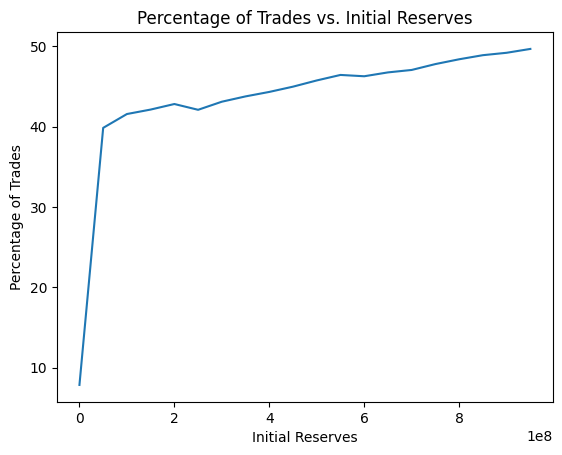

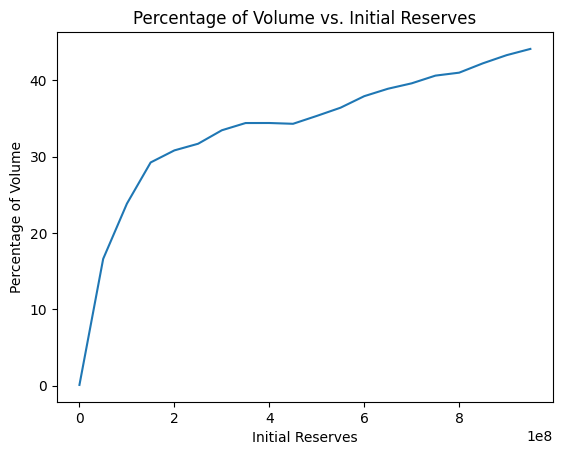

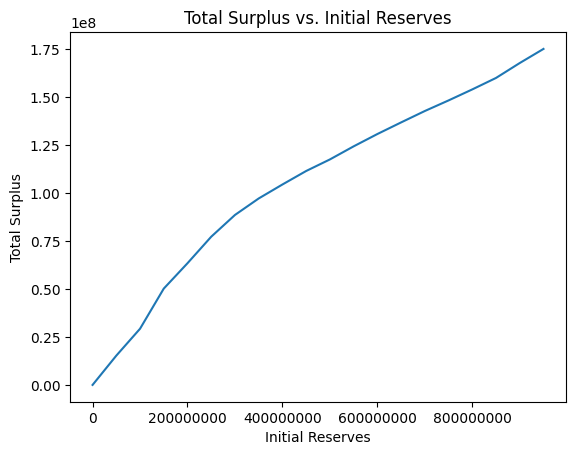

In [128]:
import matplotlib.pyplot as plt


token1 = "USDC"
token2 = "WETH"
fee_rate = 0.003 

# Study Starting reserves impact on key variables 

x = []
y1 = []
y2 = []
y3 = []


#range from 10mln to 1bn in 50mn increments for starting reserves. 
for token1_starting_reserves in range(100000, 1000100000, 50000000):
    x.append(token1_starting_reserves)
    trades_executed_percentage, executed_volume_percentage, total_surplus = surplus_analysis(token1, token2, token1_starting_reserves, fee_rate)
    y1.append(trades_executed_percentage)
    y2.append(executed_volume_percentage)
    y3.append(total_surplus)
    
    
df_results_USDC_WETH_reserves = pd.DataFrame({'starting reserves': x, '% of trades executed': y1, '% of volume executed': y2, 'total_surplus': y3})
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print('**************************************')
print('*************RESULTS******************')
print(df_results_USDC_WETH_reserves)


# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y1)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y2)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y3)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

ax.ticklabel_format(style='plain', axis='x')

plt.show()


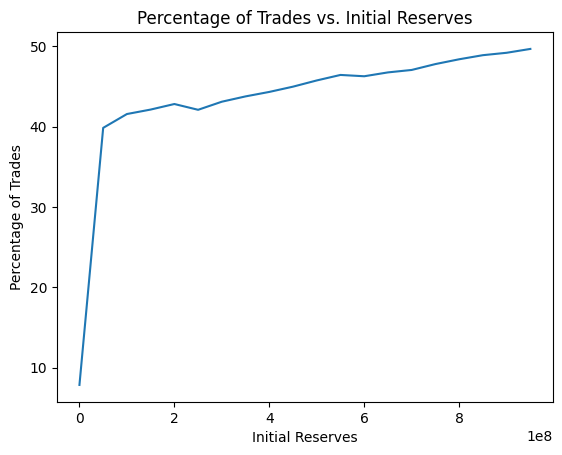

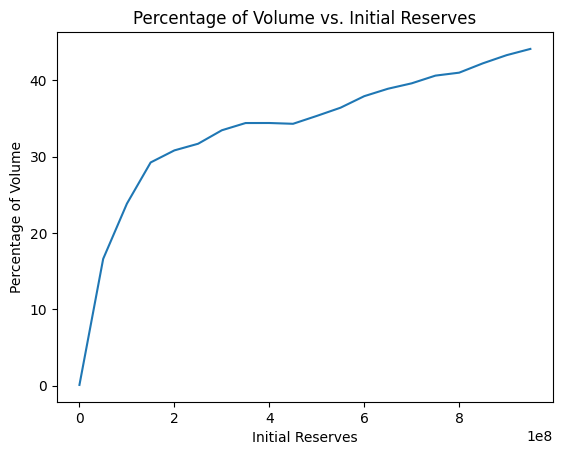

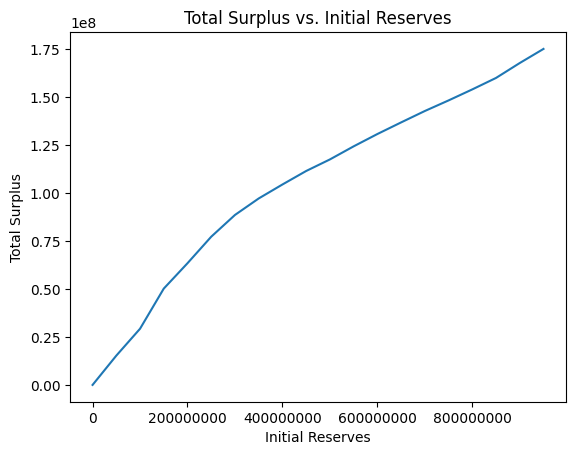

In [129]:

# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y1)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y2)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x, y3)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

ax.ticklabel_format(style='plain', axis='x')

plt.show()


#### Discussion: 

- Weird that % of trades rises and reaches a max then falls off. Thought it would be strictly increasing. 
- weird that surplus is linear wrt initial reserves


Note: 
Uni v2 USDC-WETH current reserves TVL : USD 86,620,798   
Uni v3 USDC-ETH current reserves TVL : 390,840,000 USD (Combining 0.3% pool + 0.05% pool )  

### b. Fee level 

In [144]:
import matplotlib.pyplot as plt

# starting reserves ~$100mln TVL
token1 = "USDC"
token2 = "WETH"
token1_starting_reserves = 50000000

# Study Starting reserves impact on key variables 

x_fee = []
y1_fee = []
y2_fee = []
y3_fee = []


#range from  0 - 5% increments of 0.1% for starting reserves. 
# range method only accepts integers. 
for fee_rate_int in range(0, 60, 1):
    fee_rate = fee_rate_int/1000
    x_fee.append(fee_rate)
    trades_executed_percentage, executed_volume_percentage, total_surplus = surplus_analysis(token1, token2, token1_starting_reserves, fee_rate)
    y1_fee.append(trades_executed_percentage)
    y2_fee.append(executed_volume_percentage)
    y3_fee.append(total_surplus)
    
    
df_results_USDC_WETH_fee = pd.DataFrame({'starting reserves': x_fee, '% of trades executed': y1_fee, '% of volume executed': y2_fee, 'total_surplus': y3})
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print('**************************************')
print('*************RESULTS******************')
print(df_results_USDC_WETH_fee)



# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee, y1_fee)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee, y2_fee)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee, y3_fee)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

ax.ticklabel_format(style='plain', axis='x')

plt.show()


/tmp/ipykernel_14651/2370034067.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='trades_timestamp', ascending=False, inplace=True)


dfs 17073 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.0
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 377 days, 7:07:00
  Trades:
trades executed =  7833
total_trades=  17073
percentage of trades executed =  45.87945879458795 %
  Volume:
total usd volume traded on feedlot=  289959636.8939586
total USD volume traded on COW 1537175254.2109973
volume percentage =  18.863147588385385 %
  Surplus:
total surplus 15674718.315638982
surplus percentage of volume 1.019709253886247 %
  LP metrics:
fees collected 0.0
ending reserves token1 56596173.73379365
ending reserves token2 20764.673561830157
dfs 17073 trades in sample
price column added
****** Feedlot

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.009
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 377 days, 7:07:00
  Trades:
trades executed =  5465
total_trades=  17073
percentage of trades executed =  32.009605810343814 %
  Volume:
total usd volume traded on feedlot=  212952221.87819466
total USD volume traded on COW 1537175254.2109973
volume percentage =  13.853477103201154 %
  Surplus:
total surplus 14893305.704595275
surplus percentage of volume 0.9688749323667537 %
  LP metrics:
fees collected 1916569.996903749
ending reserves token1 55192843.64317109
ending reserves token2 20147.59046465586
dfs 17073 trades in sample
price column added
****** Feedlot AMM Init

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.018
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 377 days, 7:07:00
  Trades:
trades executed =  4222
total_trades=  17073
percentage of trades executed =  24.729104433901483 %
  Volume:
total usd volume traded on feedlot=  169213862.47276717
total USD volume traded on COW 1537175254.2109973
volume percentage =  11.008104769395432 %
  Surplus:
total surplus 14440953.828323442
surplus percentage of volume 0.9394474565449408 %
  LP metrics:
fees collected 3045849.5245098094
ending reserves token1 54673976.96790987
ending reserves token2 19785.95880848353
dfs 17073 trades in sample
price column added
****** Feedlot AMM Ini

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.027
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 377 days, 7:07:00
  Trades:
trades executed =  3550
total_trades=  17073
percentage of trades executed =  20.793065073507876 %
  Volume:
total usd volume traded on feedlot=  143690698.60618868
total USD volume traded on COW 1537175254.2109973
volume percentage =  9.3477108880433 %
  Surplus:
total surplus 13851481.771612927
surplus percentage of volume 0.9010997108929281 %
  LP metrics:
fees collected 3879648.862367094
ending reserves token1 53885621.87976916
ending reserves token2 19469.250864584475
dfs 17073 trades in sample
price column added
****** Feedlot AMM Initia

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.036
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 377 days, 7:07:00
  Trades:
trades executed =  3087
total_trades=  17073
percentage of trades executed =  18.081180811808117 %
  Volume:
total usd volume traded on feedlot=  127525631.49562205
total USD volume traded on COW 1537175254.2109973
volume percentage =  8.296102291932778 %
  Surplus:
total surplus 13799273.842070928
surplus percentage of volume 0.8977033558319824 %
  LP metrics:
fees collected 4590922.733842394
ending reserves token1 53886312.05436603
ending reserves token2 19294.512334809162
dfs 17073 trades in sample
price column added
****** Feedlot AMM Init

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.045
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 377 days, 7:07:00
  Trades:
trades executed =  2734
total_trades=  17073
percentage of trades executed =  16.013588707315645 %
  Volume:
total usd volume traded on feedlot=  115053522.79209563
total USD volume traded on COW 1537175254.2109973
volume percentage =  7.4847368559254095 %
  Surplus:
total surplus 13510446.469466858
surplus percentage of volume 0.8789138670074097 %
  LP metrics:
fees collected 5177408.5256443
ending reserves token1 53610923.75582013
ending reserves token2 19073.268508949805
dfs 17073 trades in sample
price column added
****** Feedlot AMM Initi

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 2854.1551133713556
    x= 50000000
    y= 17518.319087058837
    k= 875915954352.9419
    s= 0.054
******** Results Data **********************
  Inputs:
token1 USDC
token2 WETH
initial Reserves 50000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 377 days, 7:07:00
  Trades:
trades executed =  2509
total_trades=  17073
percentage of trades executed =  14.695718385755285 %
  Volume:
total usd volume traded on feedlot=  103742856.23670782
total USD volume traded on COW 1537175254.2109973
volume percentage =  6.748928331529578 %
  Surplus:
total surplus 13306775.35132596
surplus percentage of volume 0.8656641664555077 %
  LP metrics:
fees collected 5602114.236782216
ending reserves token1 53492281.2399761
ending reserves token2 18893.090705409897
dfs 17073 trades in sample
price column added
****** Feedlot AMM Initia

ValueError: All arrays must be of the same length

In [ ]:

# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee, y1_fee)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee, y2_fee)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee, y3_fee)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

ax.ticklabel_format(style='plain', axis='x')

plt.show()


## 5. DAI-USDC – comparison with real UNIv2 returns 

**5.1 get UNI returns**

In [145]:
len(df)

331802

In [146]:
tokena = 'DAI'
tokenb = 'USDC'

In [147]:
dai_usdc_df = df[((df.buy_token_symbol == tokena) & (df.sell_token_symbol == tokenb)) | ((df.sell_token_symbol == tokena) & (df.buy_token_symbol == tokenb))]

In [148]:
dai_usdc_df = dai_usdc_df[dai_usdc_df['trades_sellAmountUsd'] > 250]
dai_usdc_df.sort_values(by='trades_timestamp', ascending=False, inplace=True)

In [149]:
len(dai_usdc_df)

6358

In [150]:
# last trade
dai_usdc_df.iloc[0,1]

1678696091

In [159]:
dai_usdc_df.iloc[0,4]

'0xa3fc82535841fe7980e3a29aa8ab641f5c41effd6a21c20ea764f45c49ce9790'

In [ ]:
#Block number last trade = 16817883
#https://etherscan.io/tx/0xa3fc82535841fe7980e3a29aa8ab641f5c41effd6a21c20ea764f45c49ce9790

In [162]:
# first trade
dai_usdc_df.iloc[-1,1]

1646123362

In [163]:
dai_usdc_df.iloc[-1,4]

'0xe9d15d88a336fcd32cf6ac9fa6da6f726e8f3a953bd00e4b208181e74e74830c'

In [164]:
# Block number first trade  = 14300014
#https://etherscan.io/tx/0xe9d15d88a336fcd32cf6ac9fa6da6f726e8f3a953bd00e4b208181e74e74830c

In [166]:
days = (datetime.utcfromtimestamp(dai_usdc_df.iloc[0,1]) - datetime.utcfromtimestamp(dai_usdc_df.iloc[-1,1]))
days

datetime.timedelta(days=376, seconds=86329)

MANUAL WORK

UNIv2 data obtained from Etherscan: Reserves values + LP token supply

DAI-USDC pool address: 0xae461ca67b15dc8dc81ce7615e0320da1a9ab8d5   
DAI Address: 0x6b175474e89094c44da98b954eedeac495271d0f   
USDC Address: 0xa0b86991c6218b36c1d19d4a2e9eb0ce3606eb48

https://etherscan.io/tokencheck-tool?t=0xB4e16d0168e52d35CaCD2c6185b44281Ec28C9Dc


In [156]:
# Univ2 data at COW data last trade:
# UNIV2 USDC_WETH Token supply @ 16817883 = 11.510319181795390492  

# UNIV2 DAI Reserves = 12,977,224.344432413558677259
# UNIV2 USDC reserves = 12,982,573.818835 

In [157]:
# Univ2 data at COW data first trade
# Block number =  14300014

# UNIV2 USDC_WETH Token supply @14300014 = 31.151563625852901815 

# UNIV2 DAI Reserves = 34,989,337.70919416559373272 DAI
# UNIV2 USDC reserves = 35,057,275.278217 USDC

In [167]:
# LP value at period end. TVL/ LP token supply
LP_token_value_end_DU = (12977224.344432413558677259+12982573.818835) / 11.510319181795390492 
LP_token_value_end_DU

2255349.98232935

In [170]:
LP_token_value_start_DU = (34989337.70919416559373272+35057275.278217 ) / 31.151563625852901815 
LP_token_value_start_DU

2248574.54440197

In [171]:
# total return for period 
r_DU = LP_token_value_end_DU/LP_token_value_start_DU
r_DU

1.0030132147249677

In [172]:
# number of days: 
annual_DU = ((r_DU -1) * 365/376 )+1
annual_DU

1.0029250621665244

In [174]:
# get volume 

uni_ds = Streamer('https://api.thegraph.com/subgraphs/name/uniswap/uniswap-v2')

In [173]:
date_gt = dai_usdc_df.iloc[-1,1]
date_gt

1646123362

In [175]:
# date_gt = weth_usdc_df.iloc[-1,1] which is 1646097479 for this simulation. Change it it accordingly below to 
# obtain the right corresponding UNIv2 volume data. 

# query COW schema: trades
uni_pool_fp = uni_ds.queryDict.get('pairDayDatas')

# trades query path that gets token a -> token b trades. Query on query_size. 
uni_pool_qp = uni_pool_fp(
    first=2000,
    orderBy='date',
    orderDirection='desc',
    where = {
    'date_gt': 1646123362,
    'pairAddress': "0xae461ca67b15dc8dc81ce7615e0320da1a9ab8d5"
    }
)

# run query
uni_pool_df_DU = uni_ds.runQuery(uni_pool_qp)

FIELD - pairDayDatas


In [176]:
len(uni_pool_df_DU)

377

In [179]:
# Total volume of USDC 
total_uni_volume_DU = uni_pool_df_DU['pairDayDatas_dailyVolumeToken0'].sum()
total_uni_volume_DU

74940235.75595757

**5.2 get Feedlot returns**

In [181]:
# run simulation with starting DAI reserves = 34989337.70919416559373272  as per the UNIv2 pool 

surplus_analysis('DAI','USDC', 34989337.70919416559373272 , 0.003)

/tmp/ipykernel_14651/2370034067.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='trades_timestamp', ascending=False, inplace=True)


dfs 6358 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1.0019219305802831
    x= 34989337.70919417
    y= 34922219.62736098
    k= 1221905336096382.2
    s= 0.003
******** Results Data **********************
  Inputs:
token1 DAI
token2 USDC
initial Reserves 34989337.70919417
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 376 days, 23:58:49
  Trades:
trades executed =  539
total_trades=  6358
percentage of trades executed =  8.477508650519031 %
  Volume:
total usd volume traded on feedlot=  1695742.0618376124
total USD volume traded on COW 1032273040.3586894
volume percentage =  0.164272628998272 %
  Surplus:
total surplus 11832.15972902581
surplus percentage of volume 0.001146223844508661 %
  LP metrics:
fees collected 5087.226185512828
ending reserves token1 34975234.36937796
ending reserves token2 34942317.49595286


(8.477508650519031, 0.164272628998272, 11832.15972902581)

In [182]:
# ending value + the fees 
ending_value_DU = 34975234.36937796 + 34942317.49595286 + 5087.226185512828
ending_value_DU

69922639.09151633

In [184]:
starting_value_DU = 34989337.70919417 + 34922219.62736098 
starting_value_DU

69911557.33655515

In [186]:
r_feedlot_DU = ending_value_DU / starting_value_DU
r_feedlot_DU

1.000158511058591

## 6. DAI-USDC Study - Variable Reserves  & Variable Fees 


Since the model is based on two variable; Starting reserves and Fee level 

will study both seperately.

a. Initial reserves variable while holding fees constant at 0.3% 

b. Holds reserves constant at current uni V2 pool reserves level and do variable fees 

### a. Initial Reserves

constant Fee level = 0.3 %
Variable: Initial Reserves

(Study range: USD 100,000 - USD 1,000,000,000)


/tmp/ipykernel_14651/2370034067.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='trades_timestamp', ascending=False, inplace=True)


dfs 2161 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1.000289271050654
    x= 100000
    y= 99971.08126028883
    k= 9997108126.028883
    s= 0.003
******** Results Data **********************
  Inputs:
token1 DAI
token2 USDT
initial Reserves 100000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 376 days, 23:08:22
  Trades:
trades executed =  61
total_trades=  2161
percentage of trades executed =  2.822767237390097 %
  Volume:
total usd volume traded on feedlot=  50173.83610561082
total USD volume traded on COW 231974138.70215723
volume percentage =  0.02162906450965701 %
  Surplus:
total surplus 1501.2559555904204
surplus percentage of volume 0.0006471652245330482 %
  LP metrics:
fees collected 150.52150831683238
ending reserves token1 100360.0402510942
ending reserves token2 100209.87547565569
dfs 2161 trades in sample
price column added
***

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1.000289271050654
    x= 450100000
    y= 449969836.75256
    k= 2.0253142352232726e+17
    s= 0.003
******** Results Data **********************
  Inputs:
token1 DAI
token2 USDT
initial Reserves 450100000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 376 days, 23:08:22
  Trades:
trades executed =  385
total_trades=  2161
percentage of trades executed =  17.81582600647848 %
  Volume:
total usd volume traded on feedlot=  11734074.614568677
total USD volume traded on COW 231974138.70215723
volume percentage =  5.0583546425554875 %
  Surplus:
total surplus 232587.08276809417
surplus percentage of volume 0.10026422948237515 %
  LP metrics:
fees collected 35202.22384370601
ending reserves token1 450032017.48802227
ending reserves token2 450220622.5450966
dfs 2161 trades in sample
price column added
****** Feedlot AMM Ini

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1.000289271050654
    x= 900100000
    y= 899839702.4238597
    k= 8.099457161517161e+17
    s= 0.003
******** Results Data **********************
  Inputs:
token1 DAI
token2 USDT
initial Reserves 900100000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 376 days, 23:08:22
  Trades:
trades executed =  436
total_trades=  2161
percentage of trades executed =  20.17584451642758 %
  Volume:
total usd volume traded on feedlot=  12671540.790930962
total USD volume traded on COW 231974138.70215723
volume percentage =  5.462479939283475 %
  Surplus:
total surplus 245479.0495191545
surplus percentage of volume 0.10582173120355319 %
  LP metrics:
fees collected 38014.62237279284
ending reserves token1 899398780.6761669
ending reserves token2 900742318.9496038
dfs 2161 trades in sample
price column added
****** Feedlot AMM Initi

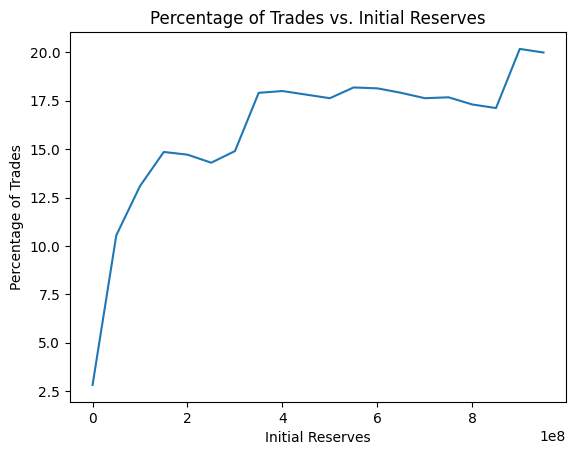

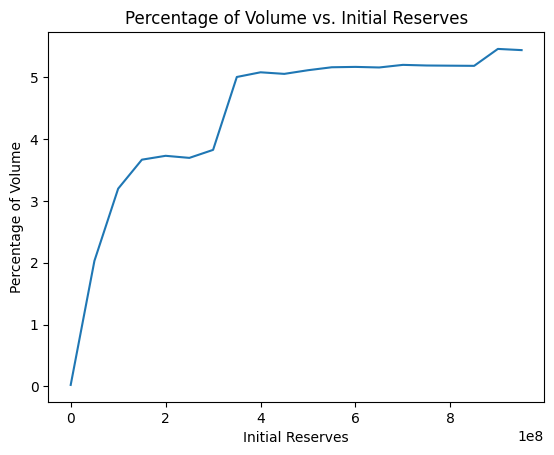

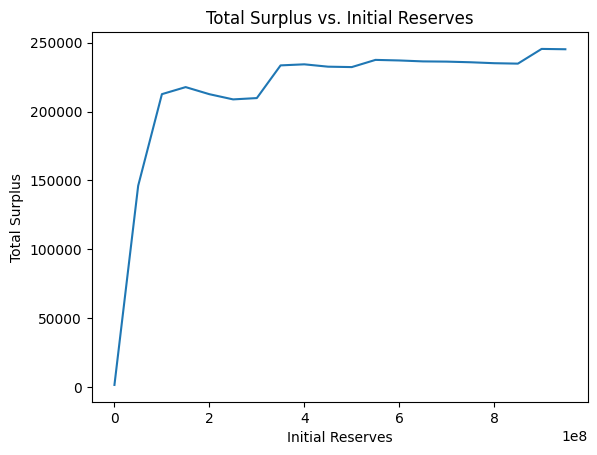

In [108]:
import matplotlib.pyplot as plt


token1 = "DAI"
token2 = "USDC"
fee_rate = 0.003

# Study Starting reserves impact on key variables 

x_DU = []
y1_DU = []
y2_DU = []
y3_DU = []


#range from 10mln to 1bn in 50mn increments for starting reserves. 
for token1_starting_reserves in range(100000, 1000100000, 50000000):
    x_DU.append(token1_starting_reserves)
    trades_executed_percentage, executed_volume_percentage, total_surplus = surplus_analysis(token1, token2, token1_starting_reserves, fee_rate)
    y1_DU.append(trades_executed_percentage)
    y2_DU.append(executed_volume_percentage)
    y3_DU.append(total_surplus)
    
    
df_results_DAI_USDC_reserves = pd.DataFrame({'starting reserves': x_DU, '% of trades executed': y1_DU, '% of volume executed': y2_DU, 'total_surplus': y3_DU})
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print('**************************************')
print('*************RESULTS******************')
print(df)


# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_DU, y1_DU)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_DU, y2_DU)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_DU, y3_DU)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

plt.show()


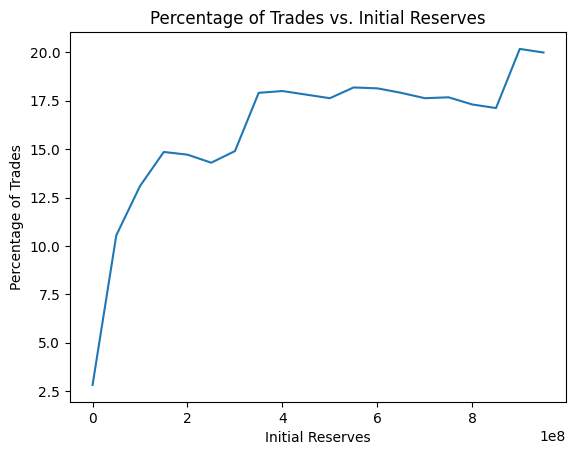

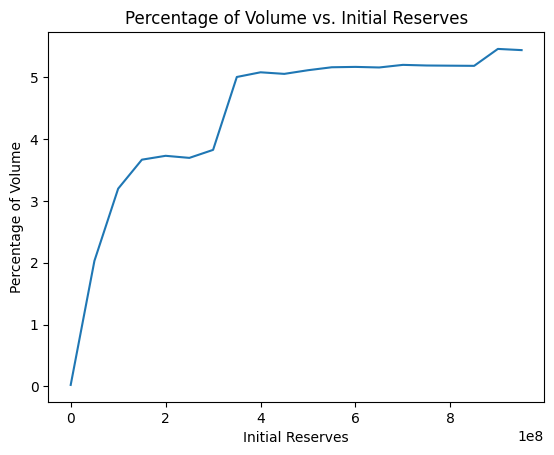

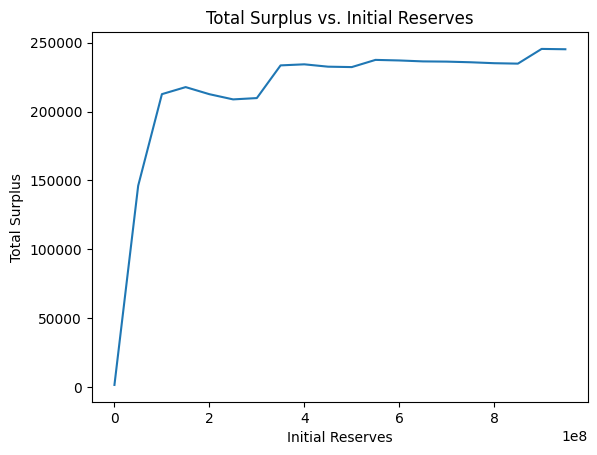

In [109]:
# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_DU, y1_DU)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_DU, y2_DU)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_DU, y3_DU)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

plt.show()


### b. Fee level 

/tmp/ipykernel_14651/2370034067.py:31: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  dfs.sort_values(by='trades_timestamp', ascending=False, inplace=True)


dfs 6358 trades in sample
price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1.0019219305802831
    x= 10000000
    y= 9980817.561512303
    k= 99808175615123.03
    s= 0.0
******** Results Data **********************
  Inputs:
token1 DAI
token2 USDC
initial Reserves 10000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 376 days, 23:58:49
  Trades:
trades executed =  1192
total_trades=  6358
percentage of trades executed =  18.748033972947468 %
  Volume:
total usd volume traded on feedlot=  5069397.49083073
total USD volume traded on COW 1032273040.3586894
volume percentage =  0.4910907572544217 %
  Surplus:
total surplus 18002.691039270052
surplus percentage of volume 0.0017439853929551972 %
  LP metrics:
fees collected 0.0
ending reserves token1 10000476.166062696
ending reserves token2 9992536.910949312
dfs 6358 trades in sample
price column added
****** Feedlot

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1.0019219305802831
    x= 10000000
    y= 9980817.561512303
    k= 99808175615123.03
    s= 0.009
******** Results Data **********************
  Inputs:
token1 DAI
token2 USDC
initial Reserves 10000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 376 days, 23:58:49
  Trades:
trades executed =  184
total_trades=  6358
percentage of trades executed =  2.8939918213274614 %
  Volume:
total usd volume traded on feedlot=  322994.6797905611
total USD volume traded on COW 1032273040.3586894
volume percentage =  0.03128965565915859 %
  Surplus:
total surplus 5426.676959179002
surplus percentage of volume 0.0005257017036203295 %
  LP metrics:
fees collected 2906.9521181150485
ending reserves token1 9990581.130982026
ending reserves token2 9992204.387250807
dfs 6358 trades in sample
price column added
****** Feedlot AMM Initi

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1.0019219305802831
    x= 10000000
    y= 9980817.561512303
    k= 99808175615123.03
    s= 0.018
******** Results Data **********************
  Inputs:
token1 DAI
token2 USDC
initial Reserves 10000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 376 days, 23:58:49
  Trades:
trades executed =  83
total_trades=  6358
percentage of trades executed =  1.3054419628814091 %
  Volume:
total usd volume traded on feedlot=  81617.32869192418
total USD volume traded on COW 1032273040.3586894
volume percentage =  0.007906564009805408 %
  Surplus:
total surplus 2243.189637750774
surplus percentage of volume 0.0002173058435170719 %
  LP metrics:
fees collected 1469.1119164546342
ending reserves token1 9987386.03085713
ending reserves token2 9994202.90734951
dfs 6358 trades in sample
price column added
****** Feedlot AMM Initial

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1.0019219305802831
    x= 10000000
    y= 9980817.561512303
    k= 99808175615123.03
    s= 0.027
******** Results Data **********************
  Inputs:
token1 DAI
token2 USDC
initial Reserves 10000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 376 days, 23:58:49
  Trades:
trades executed =  39
total_trades=  6358
percentage of trades executed =  0.6134004403900598 %
  Volume:
total usd volume traded on feedlot=  31570.876505369295
total USD volume traded on COW 1032273040.3586894
volume percentage =  0.003058384290884822 %
  Surplus:
total surplus 1189.4955203072936
surplus percentage of volume 0.00011523070678025004 %
  LP metrics:
fees collected 852.4136656449712
ending reserves token1 9987619.015312454
ending reserves token2 9993543.289175034
dfs 6358 trades in sample
price column added
****** Feedlot AMM Ini

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1.0019219305802831
    x= 10000000
    y= 9980817.561512303
    k= 99808175615123.03
    s= 0.036
******** Results Data **********************
  Inputs:
token1 DAI
token2 USDC
initial Reserves 10000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 376 days, 23:58:49
  Trades:
trades executed =  16
total_trades=  6358
percentage of trades executed =  0.2516514627241271 %
  Volume:
total usd volume traded on feedlot=  8429.091576337152
total USD volume traded on COW 1032273040.3586894
volume percentage =  0.0008165563999819516 %
  Surplus:
total surplus 529.7699398534069
surplus percentage of volume 5.1320718370144095e-05 %
  LP metrics:
fees collected 303.44729674813755
ending reserves token1 9998537.82176226
ending reserves token2 9982512.875499755
dfs 6358 trades in sample
price column added
****** Feedlot AMM Init

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1.0019219305802831
    x= 10000000
    y= 9980817.561512303
    k= 99808175615123.03
    s= 0.045
******** Results Data **********************
  Inputs:
token1 DAI
token2 USDC
initial Reserves 10000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 376 days, 23:58:49
  Trades:
trades executed =  13
total_trades=  6358
percentage of trades executed =  0.20446681346335324 %
  Volume:
total usd volume traded on feedlot=  6431.069484337152
total USD volume traded on COW 1032273040.3586894
volume percentage =  0.0006230008178943155 %
  Surplus:
total surplus 455.0190992718626
surplus percentage of volume 4.407933574568165e-05 %
  LP metrics:
fees collected 289.39812679517183
ending reserves token1 9999284.89373679
ending reserves token2 9981708.517420536
dfs 6358 trades in sample
price column added
****** Feedlot AMM Init

price column added
****** Feedlot AMM Initial State **********
AMM Initialized with the following parameters:
    initilization price = 1.0019219305802831
    x= 10000000
    y= 9980817.561512303
    k= 99808175615123.03
    s= 0.054
******** Results Data **********************
  Inputs:
token1 DAI
token2 USDC
initial Reserves 10000000
fee rate
  dataset timeframe:
starting date 2023-03-13
ending date 2022-03-01
days 376 days, 23:58:49
  Trades:
trades executed =  10
total_trades=  6358
percentage of trades executed =  0.15728216420257943 %
  Volume:
total usd volume traded on feedlot=  4804.143041177486
total USD volume traded on COW 1032273040.3586894
volume percentage =  0.00046539460524011795 %
  Surplus:
total surplus 381.58541501110443
surplus percentage of volume 3.696555078862787e-05 %
  LP metrics:
fees collected 259.42372422358426
ending reserves token1 9999451.321656918
ending reserves token2 9981499.928548172
dfs 6358 trades in sample
price column added
****** Feedlot AMM I

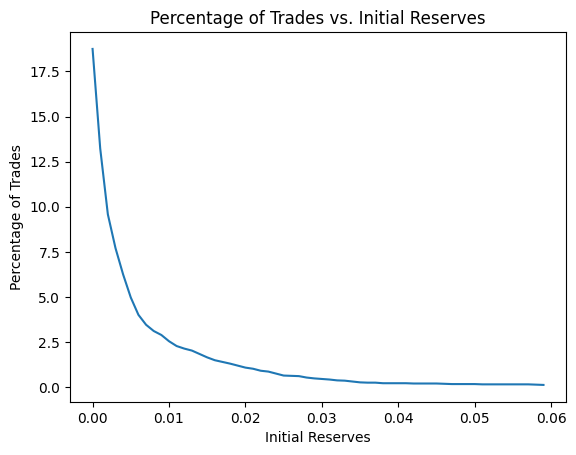

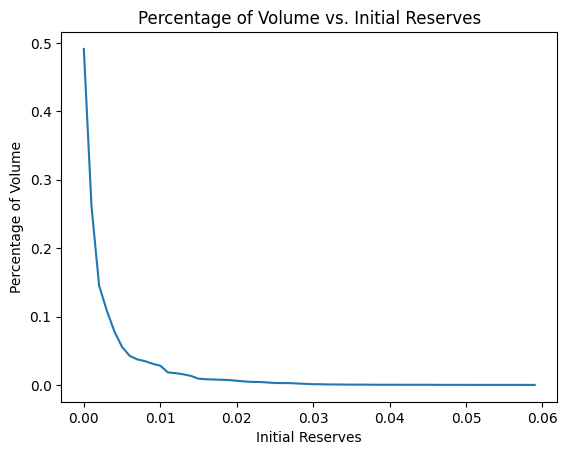

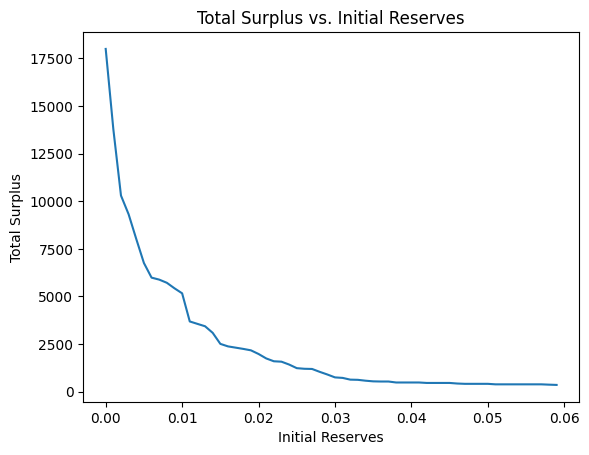

In [191]:
import matplotlib.pyplot as plt

# starting reserves ~$100mln TVL
token1 = "DAI"
token2 = "USDC"
# holding TVL ~ $20mln
token1_starting_reserves = 10000000

# Study Starting reserves impact on key variables 

x_fee_DU = []
y1_fee_DU = []
y2_fee_DU = []
y3_fee_DU = []


#range from  0 - 5% increments of 0.1% for starting reserves. 
# range method only accepts integers. 
for fee_rate_int in range(0, 60, 1):
    fee_rate = fee_rate_int/1000
    x_fee_DU.append(fee_rate)
    trades_executed_percentage, executed_volume_percentage, total_surplus = surplus_analysis(token1, token2, token1_starting_reserves, fee_rate)
    y1_fee_DU.append(trades_executed_percentage)
    y2_fee_DU.append(executed_volume_percentage)
    y3_fee_DU.append(total_surplus)
    
    
df_results_DAI_USDC_fee_DU = pd.DataFrame({'starting reserves': x_fee_DU, '% of trades executed': y1_fee_DU, '% of volume executed': y2_fee_DU, 'total_surplus': y3_fee_DU})
pd.set_option('display.float_format', lambda x: '%.4f' % x)

print('**************************************')
print('*************RESULTS******************')
print(df_results_DAI_USDC_fee_DU)



# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee_DU, y1_fee_DU)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee_DU, y2_fee_DU)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee_DU, y3_fee_DU)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

ax.ticklabel_format(style='plain', axis='x')

plt.show()


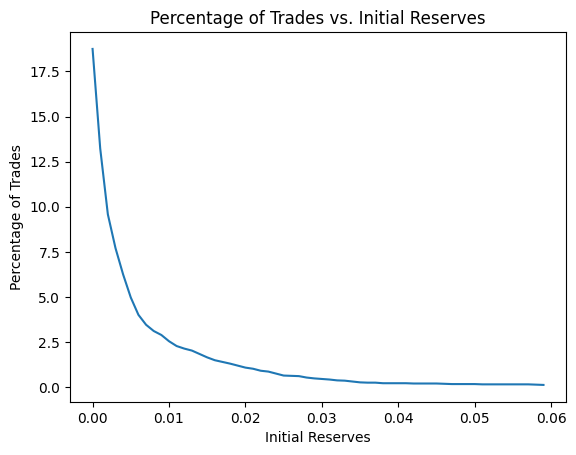

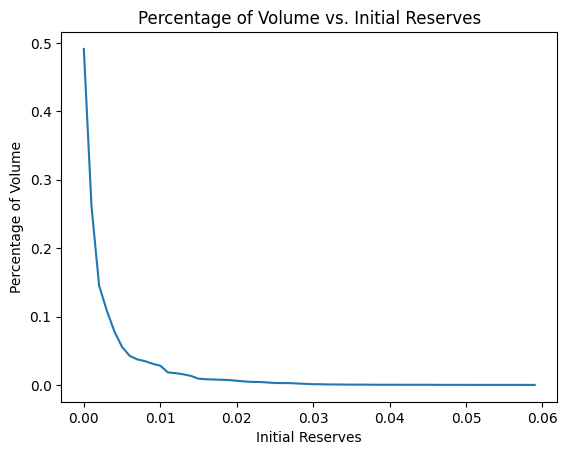

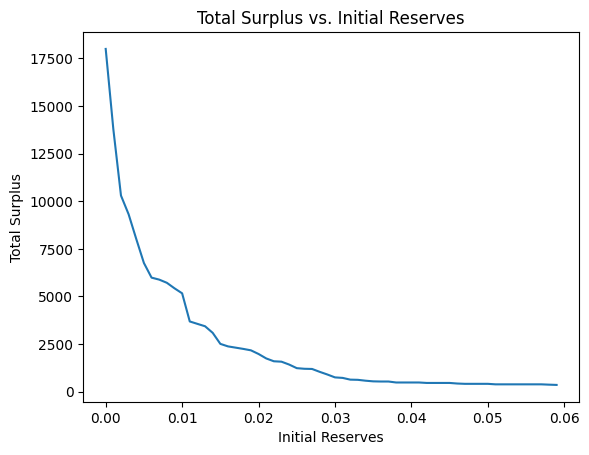

In [192]:

# Plot 1: Percentage of Trades vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee_DU, y1_fee_DU)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Trades')
ax.set_title('Percentage of Trades vs. Initial Reserves')

# Plot 2: Percentage of Volume vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee_DU, y2_fee_DU)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Percentage of Volume')
ax.set_title('Percentage of Volume vs. Initial Reserves')

# Plot 3: Total Surplus vs. Initial Reserves
fig, ax = plt.subplots()
ax.plot(x_fee_DU, y3_fee_DU)
ax.set_xlabel('Initial Reserves')
ax.set_ylabel('Total Surplus')
ax.set_title('Total Surplus vs. Initial Reserves')

ax.ticklabel_format(style='plain', axis='x')

plt.show()
